# Попробуем предсказать рецензента по названию статьи

Для этого подгрузим все названия статей и назначенных на них рецензентов.

Идея простая. На похожие названия назначаются похожие рецензенты. Значит нейросеть сможет угадать рецензента по названию. Надеюсь что  точность модели будет хотя бы 70%.

In [39]:
import pandas as pd

from google.colab import drive

drive.mount('/content/gdrive/')
data = pd.read_csv("/content/gdrive/MyDrive/data_reviewing.csv",on_bad_lines='skip',sep=";")

#https://drive.google.com/open?id=12y87nSF0tH0NXaGMyGzCfpug32u6-03b&usp=drive_copy

#data=pd.read_csv("data_articles.csv",sep=";")

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [40]:
#data = pd.read_csv("data_reviewing.csv",on_bad_lines='skip',sep=";")

In [41]:
data.columns

Index(['Рецензент', 'Организация', 'Название', 'Дата поступления',
       'Дата в работе', 'Дата решения', 'Решение', 'Молодой', 'Дата первичной',
       'Дата вторичного', 'Дата вторичной', 'Дата третичной',
       'Дата третичного', 'Дата четверичной', 'Дата четверичного',
       'Дата пятиричной', 'Дата пятиричного', 'Дата шестиничной', 'Первичное',
       'Первичная', 'Вторичное', 'Вторичная', 'Третичное', 'Третичная',
       'Четреричное', 'Четверичная', 'Пятиричное', 'Пятиричная',
       'Шестиричное'],
      dtype='object')

In [42]:
data=data[[data.columns[2],data.columns[0]]]

In [43]:
#data.head()

In [44]:
data.shape

(1652, 2)

In [45]:
! pip install pymorphy2

In [46]:
import pymorphy2
from functools import lru_cache
from multiprocessing import Pool
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook as tqdm
import re

# pymorphy2 - библиотека методов для морфологического анализа (в том числе лемматизации) русскоязычного текста
m = pymorphy2.MorphAnalyzer()

# убираем все небуквенные символы
regex = re.compile("[А-Яа-я:=!\)\()A-z\_\%/|]+")

def words_only(text, regex=regex):
    try:
        return regex.findall(text)
    except:
        return []

In [47]:
#@lru_cache(maxsize=128)
# если вы работаете не колабе, можно заменить pymorphy на mystem и раскомментирвать первую строку про lru_cache
def lemmatize(text, pymorphy=m):
    try:
        return " ".join([pymorphy.parse(w)[0].normal_form for w in text])
    except:
        return " "

In [48]:
def clean_text(text):
    return lemmatize(words_only(text))

In [49]:
%%time

# распараллелим процесс на 8 копий, чтобы ускорить,
# и к каждому объекту датасета ( = заголовку новости) применим написанную выше функцию препроцессинга
from multiprocessing import Pool
import time
from tqdm import tqdm_notebook as tqdm


#data_1["text"]=data_1["название"]+" "+lenta_part["text"]

with Pool(8) as p:
    lemmas = list(tqdm(p.imap(clean_text, data['Название']), total=len(data)))

data['lemmas'] = lemmas
#data.head()

<timed exec>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/1652 [00:00<?, ?it/s]

CPU times: user 1.01 s, sys: 163 ms, total: 1.17 s
Wall time: 5.72 s


In [50]:
data=data.drop("Название",axis=1)

In [51]:
cols = data.columns.tolist()

cols = cols[-1:] + cols[:-1]
cols

data = data[cols]


#data.head()

In [52]:
data["Рецензент"] = data["Рецензент"].str.rstrip('.')


In [53]:
len(data["Рецензент"].unique())

144

In [54]:
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

import nltk as nl

import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

import re
import nltk

nltk.download('stopwords')
nltk.download('punkt')

from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer


from nltk.corpus import stopwords

stopwords_ru = stopwords.words('russian')
stopwords_ru[:10]

from functools import lru_cache
from multiprocessing import Pool
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook as tqdm
import re
import pymorphy2
from functools import lru_cache
from multiprocessing import Pool
import numpy as np



# pymorphy2 - библиотека методов для морфологического анализа (в том числе лемматизации) русскоязычного текста
m = pymorphy2.MorphAnalyzer()

# убираем все небуквенные символы
regex = re.compile("[А-Яа-я:=!\)\()A-z\_\%/|]+")

def words_only(text, regex=regex):
    try:
        return regex.findall(text)
    except:
        return []



#@lru_cache(maxsize=128)
# если вы работаете не колабе, можно заменить pymorphy на mystem и раскомментирвать первую строку про lru_cache
def lemmatize(text, pymorphy=m):
    try:
        return " ".join([pymorphy.parse(w)[0].normal_form for w in text])
    except:
        return " "



def clean_text(text):
    return lemmatize(words_only(text))

def words_only(text, regex=regex):
    try:
        return regex.findall(text)
    except:
        return []


def lemmatize(text, pymorphy=m):
    try:
        return " ".join([pymorphy.parse(w)[0].normal_form for w in text])
    except:
        return " "


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [55]:
%%time

train = []

#берем только title
for sentences in data[data.columns[0:1]].values:
    train.extend(sentences)

# Create an array of tokens using nltk
tokens = [nl.word_tokenize(sentences) for sentences in train]


train_y = []


#берет только топики
for sentences in data[data.columns[1:2]].values:
    train_y.extend(sentences)

# Create an array of tokens using nltk
tokens_y = [nl.word_tokenize(sentences) for sentences in train_y]

print("tokens",len(tokens),"tokens_y",len(tokens_y))

Y_dataset = train_y #lenta_part["topic"]

#print("dataset",len(Y_dataset))

tokens 1652 tokens_y 1652
CPU times: user 267 ms, sys: 0 ns, total: 267 ms
Wall time: 267 ms


In [56]:
#from transformers import GensimWord2VecVectorizer

In [57]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from gensim.models import Word2Vec
#from gensim.models.word2vec import Word2Vec
#from gensim.models.word2vec import Word2Vec


class GensimWord2VecVectorizer(BaseEstimator, TransformerMixin):
    """
    Word vectors are averaged across to create the document-level vectors/features.
    gensim's own gensim.sklearn_api.W2VTransformer doesn't support out of vocabulary words,
    hence we roll out our own.
    All the parameters are gensim.models.Word2Vec's parameters.
    https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec
    """

    def __init__(self, size=10, alpha=0.25, window=5, min_count=5, max_vocab_size=None,
                 sample=0.001, seed=1, workers=3, min_alpha=0.0001, sg=0, hs=0, negative=5,
                 ns_exponent=0.75, cbow_mean=1, hashfxn=hash, iter=5, null_word=0,
                 trim_rule=None, sorted_vocab=1, batch_words=100, compute_loss=False,
                 callbacks=(), max_final_vocab=None):
        self.size = size
        self.alpha = alpha
        self.window = window
        self.min_count = min_count
        self.max_vocab_size = max_vocab_size
        self.sample = sample
        self.seed = seed
        self.workers = workers
        self.min_alpha = min_alpha
        self.sg = sg
        self.hs = hs
        self.negative = negative
        self.ns_exponent = ns_exponent
        self.cbow_mean = cbow_mean
        self.hashfxn = hashfxn
        self.iter = iter
        self.null_word = null_word
        self.trim_rule = trim_rule
        self.sorted_vocab = sorted_vocab
        self.batch_words = batch_words
        self.compute_loss = compute_loss
        self.callbacks = callbacks
        self.max_final_vocab = max_final_vocab

    def fit(self, X, y=None):
        self.model_ = Word2Vec(
            sentences=X, corpus_file=None,
            size=self.size, alpha=self.alpha, window=self.window, min_count=self.min_count,
            max_vocab_size=self.max_vocab_size, sample=self.sample, seed=self.seed,
            workers=self.workers, min_alpha=self.min_alpha, sg=self.sg, hs=self.hs,
            negative=self.negative, ns_exponent=self.ns_exponent, cbow_mean=self.cbow_mean,
            hashfxn=self.hashfxn, iter=self.iter, null_word=self.null_word,
            trim_rule=self.trim_rule, sorted_vocab=self.sorted_vocab, batch_words=self.batch_words,
            compute_loss=self.compute_loss, callbacks=self.callbacks,
            max_final_vocab=self.max_final_vocab)
        return self

    def transform(self, X):
        X_embeddings = np.array([self._get_embedding(words) for words in X])
        return X_embeddings

    def _get_embedding(self, words):
        valid_words = [word for word in words if word in self.model_.wv.vocab]
        if valid_words:
            embedding = np.zeros((len(valid_words), self.size), dtype=np.float32)
            for idx, word in enumerate(valid_words):
                embedding[idx] = self.model_.wv[word]

            return np.mean(embedding, axis=0)
        else:
            return np.zeros(self.size)

!! Чтобы обучать модели необходимо представить целевую переменную в числовом виде, для начала нужно преобразовать ваш объект (это список в внутри которого список из одного элемента) в просто список элементов

In [58]:
%%time

gensim_word2vec_tr = GensimWord2VecVectorizer(size=30, min_count=1, sg=1, alpha=0.15, iter=5)
xgb = XGBClassifier(learning_rate=0.075, n_estimators=30, n_jobs=-1)
w2v_xgb = Pipeline([
    ('w2v', gensim_word2vec_tr),
    ('xgb', xgb)
])
w2v_xgb

X_train, X_test, y_train, y_test = train_test_split(tokens, tokens_y,
                                                    test_size = 0.30,random_state=42
                                                    )

print("\n Training the word2vec model...\n")


#y_test


 Training the word2vec model...

CPU times: user 1.79 ms, sys: 0 ns, total: 1.79 ms
Wall time: 1.71 ms


Затем необходимо преобразовать каждую фамилию в цифру, с помощью OrdinalEncoder пример из документации

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html

```python
>>> from sklearn.preprocessing import OrdinalEncoder
>>> enc = OrdinalEncoder()
>>> X = [['Male', 1], ['Female', 3], ['Female', 2]]
>>> enc.fit(X)
OrdinalEncoder()
>>> enc.categories_
[array(['Female', 'Male'], dtype=object), array([1, 2, 3], dtype=object)]
>>> enc.transform([['Female', 3], ['Male', 1]])
array([[0., 2.],
       [1., 0.]])

>>> enc.inverse_transform([[1, 0], [0, 1]])
array([['Male', 1],
       ['Female', 2]], dtype=object)
```

In [59]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder

#le = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

le = LabelEncoder()

le.fit(np.array(y_train).reshape(-1,1))

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.fit_transform(y_test)

#y_train_encoded = le.transform(np.array(y_train).reshape(-1,1))
#y_test_encoded = le.transform(np.array(y_test).reshape(-1,1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [60]:
## просто убираем лишнюю вложенность
#tokens_y[0]
#print('Было:', y_train[:2])

#print('Стало:', y_train_encoded[:2])

#print('Обратное преобразование:', le.inverse_transform(y_train_encoded[:2]))

#type(y_train_encoded[0][0])

In [61]:
start = time.time()
w2v_xgb.fit(X_train, y_train_encoded)
elapse = time.time() - start
print('elapsed: ', elapse)
#w2v_xgb

y_train_pred = w2v_xgb.predict(X_train)
print('Training set accuracy %s' % accuracy_score(y_train_encoded, y_train_pred))
confusion_matrix(y_train_encoded, y_train_pred)

y_test_pred = w2v_xgb.predict(X_test)
print('Test set accuracy %s' % accuracy_score(y_test_encoded, y_test_pred))
confusion_matrix(y_test_encoded, y_test_pred)


TypeError: ignored

Чтобы понять насколько хорошее качество можно сравниться со случайным предсказанием или константным

In [ ]:
print('Test set accuracy %s' % accuracy_score(y_test_encoded, y_test_pred))

In [ ]:
values, counts = np.unique(y_train_encoded, return_counts=True)

In [ ]:
ind = np.argmax(counts)
print(values[ind])

In [ ]:
most_freq_preds = np.zeros_like(y_test_pred)
most_freq_preds.fill(values[ind])
print('Test set accuracy with most freq pred', accuracy_score(y_test_encoded, most_freq_preds))

Тут можно сказать что алгоритм сильно переобучен на трэйне и плохо предсказывает тестовую выборку (
    

In [ ]:
# start = time.time()
# w2v_xgb.fit(X_train, y_train_pred)
# elapse = time.time() - start
# print('elapsed: ', elapse)
# #w2v_xgb

# y_train_pred = w2v_xgb.predict(X_train)
# print('Training set accuracy %s' % accuracy_score(y_train, y_train_pred))
# confusion_matrix(y_train, y_train_pred)

# y_test_pred = w2v_xgb.predict(X_test)
# print('Test set accuracy %s' % accuracy_score(y_test, y_test_pred))
# confusion_matrix(y_test, y_test_pred)


# Пробуем KeyText

Пробуем названия и рецензентов вычленить KeyText()

In [62]:
# переводим данные из датафрейма в списки
X = data["lemmas"].tolist()
y = data["Рецензент"].tolist()

X, y = np.array(X), np.array(y)

# разбиваем на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33)
print ("total train examples %s" % len(y_train))
print ("total test examples %s" % len(y_test))

total train examples 1106
total test examples 546


In [63]:
with open('data.train.txt', 'w+') as outfile:
    for i in range(len(X_train)):
        outfile.write('__label__' + y_train[i] + ' '+ X_train[i] + '\n')

with open('test.txt', 'w+') as outfile:
    for i in range(len(X_test)):
        outfile.write('__label__' + y_test[i] + ' ' + X_test[i] + '\n')

In [64]:
! git clone https://github.com/facebookresearch/fastText.git
! pip install fastText/.

fatal: destination path 'fastText' already exists and is not an empty directory.
Processing ./fastText
  Preparing metadata (setup.py) ... done
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4290347 sha256=c84f538523a524951ab959b1055da8d87c253fcc9257e2ac2f15c1373f68a8d4
  Stored in directory: /tmp/pip-ephem-wheel-cache-jw90yafw/wheels/8b/05/af/3cfae069d904597d44b309c956601b611bdf8967bcbe968903
Successfully built fasttext
  Attempting uninstall: fasttext
    Found existing installation: fasttext 0.9.2
    Uninstalling fasttext-0.9.2:
      Successfully uninstalled fasttext-0.9.2


In [65]:
import fasttext

classifier = fasttext.train_supervised('data.train.txt')
result = classifier.test('test.txt')

In [66]:
print('P@1:', result[1])
print('R@1:', result[2])
print('Number of examples:', result[0])

P@1: 0.28785046728971964
R@1: 0.28785046728971964
Number of examples: 535


In [67]:
X = data["lemmas"].tolist()
y = data["Рецензент"].tolist()

X, y = np.array(X), np.array(y)

keytext_y=[]

X_os=[]


for i in range(1,99):

  X_os.append(i/100)
  X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=i/100,random_state=42)

  with open('data.train.txt', 'w+') as outfile:
      for i in range(len(X_train)):
          outfile.write('__label__' + y_train[i] + ' '+ X_train[i] + '\n')

  with open('test.txt', 'w+') as outfile:
      for i in range(len(X_test)):
          outfile.write('__label__' + y_test[i] + ' ' + X_test[i] + '\n')
  classifier = fasttext.train_supervised('data.train.txt')
  result = classifier.test('test.txt')
  keytext_y.append(result[1])

In [68]:
start = time.time()


Train_G=[]
Test_G=[]

train = []

#берем только title
for sentences in data[data.columns[0:1]].values:
    train.extend(sentences)

# Create an array of tokens using nltk
tokens = [nl.word_tokenize(sentences) for sentences in train]


train_y = []

for sentences in data[data.columns[1:2]].values:
    train_y.extend(sentences)



# Create an array of tokens using nltk
tokens_y = [nl.word_tokenize(sentences) for sentences in train_y]



for i in range(1,99):
  X_train, X_test, y_train, y_test = train_test_split(tokens, tokens_y, test_size = i/100,random_state=42)

#  X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=i/100,random_state=42)

  #le.fit(np.array(y_train).reshape(-1,1))
  y_train_encoded = le.fit_transform(y_train)
  y_test_encoded = le.fit_transform(y_test)

  #y_train_encoded = le.transform(np.array(y_train).reshape(-1,1))
  #y_test_encoded = le.transform(np.array(y_test).reshape(-1,1))

  #w2v_xgb.fit(X_train, y_train_encoded)

  elapse = time.time() - start

  print('elapsed: ', elapse)
  #w2v_xgb

  #y_train_pred = w2v_xgb.predict(X_train)
  #print('Training set accuracy %s' % accuracy_score(y_train_encoded, y_train_pred))
  #Train_G.append(accuracy_score(y_train_encoded, y_train_pred))
  #confusion_matrix(y_train_encoded, y_train_pred)

  #y_test_pred = w2v_xgb.predict(X_test)
  #print('Test set accuracy %s' % accuracy_score(y_test_encoded, y_test_pred))
  #Test_G.append(accuracy_score(y_test_encoded, y_test_pred))
  #confusion_matrix(y_test_encoded, y_test_pred)




/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

elapsed:  0.7450766563415527
elapsed:  0.7488424777984619
elapsed:  0.7551155090332031
elapsed:  0.7656254768371582
elapsed:  0.7740268707275391
elapsed:  0.7837042808532715
elapsed:  0.7881612777709961
elapsed:  0.8035597801208496
elapsed:  0.826047420501709
elapsed:  0.8313367366790771
elapsed:  0.837515115737915
elapsed:  0.8430867195129395
elapsed:  0.8486087322235107
elapsed:  0.8533444404602051
elapsed:  0.8581593036651611
elapsed:  0.8628044128417969
elapsed:  0.8660628795623779
elapsed:  0.8740866184234619
elapsed:  0.8832526206970215
elapsed:  0.8945274353027344
elapsed:  0.9035038948059082
elapsed:  0.9107096195220947
elapsed:  0.9225778579711914
elapsed:  0.9341964721679688
elapsed:  0.9469203948974609


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

elapsed:  0.962216854095459
elapsed:  0.9655330181121826
elapsed:  0.9747159481048584
elapsed:  0.9780688285827637
elapsed:  0.9865624904632568
elapsed:  1.0014572143554688
elapsed:  1.0047125816345215
elapsed:  1.014195442199707
elapsed:  1.0174994468688965
elapsed:  1.0278594493865967
elapsed:  1.0311739444732666
elapsed:  1.045576810836792
elapsed:  1.049060344696045
elapsed:  1.0542657375335693
elapsed:  1.0659170150756836
elapsed:  1.0742599964141846
elapsed:  1.0805225372314453
elapsed:  1.0864126682281494
elapsed:  1.0911469459533691
elapsed:  1.0972533226013184
elapsed:  1.1049654483795166
elapsed:  1.1122980117797852
elapsed:  1.1202101707458496
elapsed:  1.1271750926971436
elapsed:  1.1332578659057617
elapsed:  1.138293743133545
elapsed:  1.1433510780334473
elapsed:  1.1503801345825195
elapsed:  1.1604349613189697
elapsed:  1.1712279319763184
elapsed:  1.1795759201049805
elapsed:  1.185720443725586


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

elapsed:  1.2001285552978516
elapsed:  1.2056183815002441
elapsed:  1.2131922245025635
elapsed:  1.2182538509368896
elapsed:  1.2279527187347412
elapsed:  1.2353224754333496
elapsed:  1.242142677307129
elapsed:  1.2466976642608643
elapsed:  1.2511646747589111
elapsed:  1.255586862564087
elapsed:  1.260071039199829
elapsed:  1.2644243240356445
elapsed:  1.2691466808319092
elapsed:  1.2734873294830322
elapsed:  1.2777254581451416
elapsed:  1.282426118850708
elapsed:  1.2875022888183594
elapsed:  1.292083501815796
elapsed:  1.2959699630737305
elapsed:  1.3001866340637207
elapsed:  1.3049850463867188
elapsed:  1.3091826438903809
elapsed:  1.31361985206604
elapsed:  1.3167426586151123
elapsed:  1.3198769092559814
elapsed:  1.323312759399414
elapsed:  1.3263144493103027
elapsed:  1.3296563625335693
elapsed:  1.332648515701294
elapsed:  1.3357141017913818
elapsed:  1.3388359546661377
elapsed:  1.341970443725586
elapsed:  1.3451473712921143
elapsed:  1.348102331161499
elapsed:  1.3523356914520

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

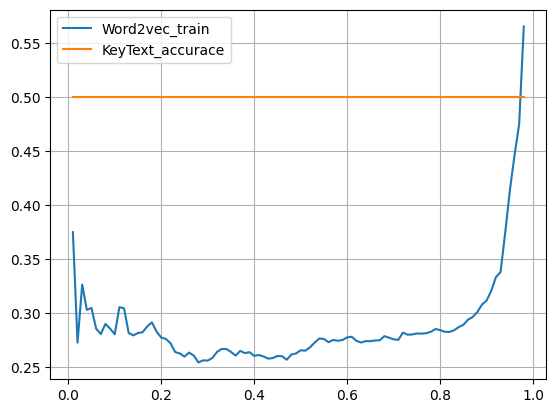

In [69]:
#from mathplotlib import plot

#from matplotlib.pyplot import plot

import matplotlib.pyplot as plt



#plt.plot(X_os,Train_G,label='Train')
plt.plot(X_os,keytext_y,label='Test')
#plt.plot(X_os,Test_G,label='test')
plt.plot(X_os,[0.5 for i in range(1,99)],label='test')


plt.legend(['Word2vec_train',"KeyText_accurace","Word2Vec_test"])
plt.grid(True)

#plt.plot(X,Test_G,label='Test')

#plt.legend(['test'])
#Train_G[:][1]#, Train_G[2,:]